In [1]:
# Using pandas to process data
from collections import Counter
import numpy as np
import pandas as pd
import datetime
from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import pearsonr

from utils.data_util import load_bj_aq_data, generate_model_data
# from utils.plot_util import plot_station, plot_stations

%load_ext autoreload
%autoreload 2

### 1. 数据载入

In [2]:
bj_aq_data, stations, bj_aq_stations, bj_aq_stations_merged = load_bj_aq_data()

In [3]:
bj_aq_stations_merged.head()

,yongdingmennei_aq_PM2.5,yongdingmennei_aq_PM10,yongdingmennei_aq_NO2,yongdingmennei_aq_CO,yongdingmennei_aq_O3,yongdingmennei_aq_SO2,shunyi_aq_PM2.5,shunyi_aq_PM10,shunyi_aq_NO2,shunyi_aq_CO,...,yizhuang_aq_CO,yizhuang_aq_O3,yizhuang_aq_SO2,yanqin_aq_PM2.5,yanqin_aq_PM10,yanqin_aq_NO2,yanqin_aq_CO,yanqin_aq_O3,yanqin_aq_SO2,order
time,,,,,,,,,,,,,,,,,,,,,
2017-01-01 14:00:00,415.0,NaN,143.0,6.7,12.0,12.0,386.0,477.0,116.0,6.3,...,5.7,6.0,2.0,206.0,227.0,84.0,4.4,43.0,45.0,0
2017-01-01 15:00:00,409.0,NaN,143.0,0.7,12.0,13.0,410.0,476.0,121.0,6.3,...,5.8,6.0,3.0,218.0,246.0,83.0,5.3,49.0,47.0,1
2017-01-01 16:00:00,401.0,NaN,134.0,7.1,12.0,11.0,418.0,493.0,118.0,6.8,...,6.1,6.0,2.0,146.0,NaN,58.0,2.5,40.0,39.0,2
2017-01-01 17:00:00,407.0,NaN,126.0,7.2,12.0,10.0,474.0,532.0,133.0,7.9,...,6.3,6.0,3.0,134.0,169.0,69.0,4.2,40.0,28.0,3
2017-01-01 18:00:00,415.0,NaN,142.0,7.3,13.0,12.0,449.0,456.0,137.0,7.3,...,6.4,7.0,3.0,175.0,NaN,71.0,5.1,41.0,31.0,4


## 2. 相同特征不同站点之间的相关性

In [213]:
# 站点的具体位置
station_locations = pd.read_excel("./KDD_CUP_2018/Beijing/location/Beijing_AirQuality_Stations_locations.xlsx")
station_locations.head()

,stationName,longitude,latitude
0,dongsi_aq,116.417,39.929
1,tiantan_aq,116.407,39.886
2,guanyuan_aq,116.339,39.929
3,wanshouxigong_aq,116.352,39.878
4,aotizhongxin_aq,116.397,39.982


In [241]:
station_locations["longitude"].values.min()

115.97199999999999

In [210]:
def caculate_distance(station_1, station_2, station_locations):
    '''
    station_1, station_2 : names of two stations
    station_locations : a dataframe of "stationName", "longitude", "latitude"
    '''
    location_1 = station_locations[station_1+"_aq" == station_locations["stationName"]]
    location_2 = station_locations[station_2+"_aq" == station_locations["stationName"]]
    dis = np.sqrt((location_1["longitude"].values[0] - location_2["longitude"].values[0])**2 + 
                  (location_1["latitude"].values[0] - location_2["latitude"].values[0])**2)
    return dis

In [258]:
def caculate_r_distance_relations(dataframe, feature):
    '''
    dataframe : dataframe with all data.
    feature : feature that you want to compare.
    '''
    features = [name for name in dataframe.columns if feature in name]
    df = dataframe[features]
    
    relations = pd.DataFrame(columns=["station_1", "station_2", "r", "distance"])
    for i in range(len(features)-1):
        for j in range(i+1,len(features)):
            station_1 = features[i].split("_")[0]
            station_2 = features[j].split("_")[0]
            ts_station_1 = df[features[i]]
            ts_station_2 = df[features[j]]
            r = pearsonr(ts_station_1, ts_station_2)[0]
            distance = caculate_distance(station_1, station_2, station_locations)
            s = pd.Series({"station_1":station_1, "station_2":station_2, "r":r, "distance":distance})
            relations = relations.append(s,ignore_index=True)
    
    # 按照相关系数降序排序
    relations = relations.sort_values(by=['r'], ascending=False)

    plt.subplot(2,1,1)
    plt.plot(range(len(relations)), relations['r']);
    plt.subplot(2,1,2)
    plt.plot(range(len(relations)), relations['distance']);

    # “相关系数的降低” 与 “站点之间的距离” 存在一定的正相关关系
    # “距离” 与 “相关性” 存在负相关关系
    # print("The range of pearsonr between stations of feature %s are between %d and %d" %(feature, relations["r"].values.min(), relations["r"].values.max()))
    
    r = pearsonr(relations["r"].values, relations['distance'].values)[0]
    # print("r = ", pearsonr(relations["r"].values, relations['distance'].values)[0])
    
    return relations, r

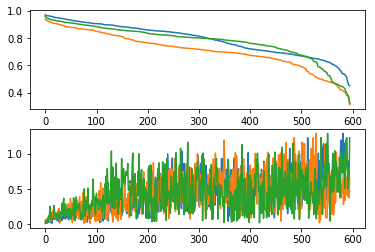

In [259]:
for feature in ["PM2.5", "PM10", "O3"]:
    relations, r = caculate_r_distance_relations(bj_aq_stations_merged, feature)

## 3. 空气质量的“天”的周期性

In [309]:
bj_aq_stations_merged['new'] = bj_aq_stations_merged.index
bj_aq_stations_merged['new'] = pd.to_datetime(bj_aq_stations_merged['new'])

In [367]:
df = bj_aq_stations_merged[["new", "fangshan_aq_PM2.5"]]

In [368]:
# initial values
d = datetime.timedelta(hours=24)
t_start = datetime.datetime(2017,1,2,0,0,0)
t_end = datetime.datetime(2017,1,3,0,0,0)

In [369]:
feature = "fangshan_aq_PM2.5"
all_days = []
all_days_dfs = []
for i in range(445):
    df = bj_aq_stations_merged[["new", feature]]
    df_part = df[df['new'] < t_end]
    df_part = df_part[df_part['new'] >= t_start]
    
    all_days.append(df_part[feature].values)
    all_days_dfs.append(df_part)
    t_start += d
    t_end += d

In [373]:
bias_all_days = []
for day in all_days:
    if len(day) == 24 : 
        init = day[0]
        bias_day = [i - init for i in day]
        bias_all_days.append(bias_day)

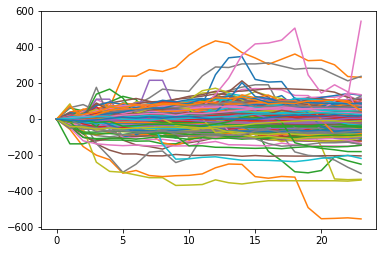

In [376]:
for bias_all_day in bias_all_days:
    plt.plot(bias_all_day)

In [379]:
bias_all_days = np.array(bias_all_days)

In [383]:
day = np.mean(bias_all_days, axis=0)

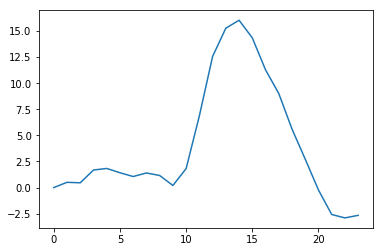

In [386]:
plt.plot(day);

# 数据的下载补齐

- 空气质量数据
    - 10298 data for 35 stations
    - 2017:01:01 14:00 - 2018:03:31 15:00 

In [26]:
# 原有 aq 数据的范围
print(min(bj_aq_data.index), max(bj_aq_data.index))

2017-01-01 14:00:00 2018-03-31 15:00:00


In [30]:
# 新下载的 aq 数据
bj_aq_dataset_new = pd.read_csv("./KDD_CUP_2018/Beijing/aq/bj_airquality_2018-03-31-15-2018-04-15-23.csv")
bj_aq_dataset_new.head()

,id,station_id,time,PM25_Concentration,PM10_Concentration,NO2_Concentration,CO_Concentration,O3_Concentration,SO2_Concentration
0,2941450,dongsi_aq,2018-03-31 07:00:00,105.0,172.0,53.0,0.8,127.0,14.0
1,2941451,tiantan_aq,2018-03-31 07:00:00,95.0,123.0,54.0,0.9,121.0,15.0
2,2941452,guanyuan_aq,2018-03-31 07:00:00,95.0,139.0,66.0,0.8,123.0,13.0
3,2941453,wanshouxigong_aq,2018-03-31 07:00:00,99.0,172.0,58.0,1.0,119.0,14.0
4,2941454,aotizhongxin_aq,2018-03-31 07:00:00,117.0,166.0,67.0,0.8,111.0,14.0


In [31]:
length = bj_aq_dataset_new.shape[0]
formet_time = pd.Series([datetime.datetime.strptime(bj_aq_dataset_new["time"][i],'%Y-%m-%d %H:%M:%S') for i in range(length)])
bj_aq_dataset_new["format_time"] = formet_time
bj_aq_dataset_new.set_index("format_time", inplace=True)

In [33]:
# 新下载的 aq 数据的范围
print(min(bj_aq_dataset_new.index), max(bj_aq_dataset_new.index))

2018-03-31 07:00:00 2018-04-15 23:00:00


# ChangeLog
- 0419 对新下载的数据进行了数据探索
- 0423
     - 增加对不同站点的相同特征之间的相关性分析
     - 增加对空气质量的天的周期性
- TODO
    - 新下载的数据和之前的数据在时间轴上有重叠的部分，同时原始的数据有很大部分的缺失，可以使用新下载的数据对原始数据进行补齐
    - 分析之前的数据中，不同站点的时间轴缺失情况是怎么样的，如果有大段的缺失，建议丢弃该片段
        - 对于短期的 + 个别的缺失，使用插值的方式进行补全
        - 对于长期的 + 全特征的缺失，将对应的数据删除